## Geometric operations
### Overlay analysis
In this tutorial, the aim is to make an overlay analysis where we create a new layer based on geometries from a dataset that intersect with geometries of another layer. As our test case, we will select Polygon grid cells from TravelTimes_to_5975375_RailwayStation_Helsinki.shp that intersects with municipality borders of Helsinki found in Helsinki_borders.shp.

In [124]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
%matplotlib inline
from pyproj import CRS

# File paths
border_fp = "data/Helsinki_borders.shp"
grid_fp = "data/TravelTimes_to_5975375_RailwayStation.shp"

# Read files
grid = gpd.read_file(grid_fp)
hel = gpd.read_file(border_fp)

<AxesSubplot:>

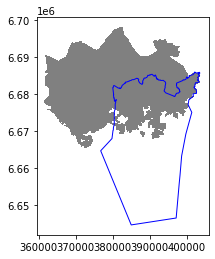

In [2]:
# Plot the layers
ax = grid.plot(facecolor='gray')
hel.plot(ax=ax, facecolor='None', edgecolor='blue')

In [3]:
grid.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


In [4]:
hel.head()

,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,27517366,Helsinki,Helsingfors,091,"POLYGON ((399936.363 6684600.244, 399937.630 6..."


Here the grey area is the Travel Time Matrix - a data set that contains 13231 grid squares (13231 rows of data) that covers the Helsinki region, and the blue area represents the municipality of Helsinki. Our goal is to conduct an overlay analysis and select the geometries from the grid polygon layer that intersect with the Helsinki municipality polygon.

When conducting overlay analysis, it is important to first check that the CRS of the layers match. The overlay visualization indicates that everything should be ok (the layers are plotted nicely on top of each other). However, let’s still check if the crs match using Python:

In [5]:
# Ensure that the CRS matches, if not raise an AssertionError
assert hel.crs == grid.crs, "CRS differs between layers!"

Indeed, they do. We are now ready to conduct an overlay analysis between these layers.

We will create a new layer based on grid polygons that intersect with our Helsinki layer. We can use a function called overlay() to conduct the overlay analysis that takes as an input 1) first GeoDataFrame, 2) second GeoDataFrame, and 3) parameter how that can be used to control how the overlay analysis is conducted (possible values are 'intersection', 'union', 'symmetric_difference', 'difference', and 'identity'):

<AxesSubplot:>

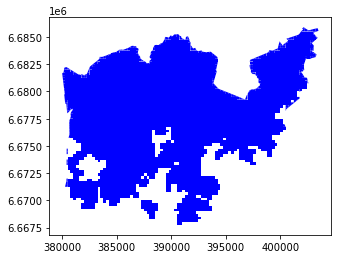

In [6]:
intersection = gpd.overlay(grid, hel, how='intersection')
intersection.plot(color="b")

In [7]:
intersection.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.224 6685750.000, 402003.328 6..."
1,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6..."
2,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.515 6685750.000, 403243.781 6..."
3,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6..."
4,29411,40,29418,44,5878128,29944,75,95,24938,76,99,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((401900.425 6685500.000, 402000.000 6..."


As we can see, due to the overlay analysis, the dataset contains the attributes from both input layers.

Let’s save our result grid as a GeoJSON file that is commonly used file format nowadays for storing spatial data.

In [8]:
# Output filepath
outfp = "data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

# Use GeoJSON driver
intersection.to_file(outfp, driver="GeoJSON")

### Aggregating data
Data aggregation refers to a process where we combine data into groups. When doing spatial data aggregation, we merge the geometries together into coarser units (based on some attribute), and can also calculate summary statistics for these combined geometries from the original, more detailed values. For example, suppose that we are interested in studying continents, but we only have country-level data like the country dataset. If we aggregate the data by continent, we would convert the country-level data into a continent-level dataset.

In this tutorial, we will aggregate our travel time data by car travel times (column car_r_t), i.e. the grid cells that have the same travel time to Railway Station will be merged together.

For doing the aggregation we will use a function called dissolve() that takes as input the column that will be used for conducting the aggregation:

In [9]:
# Conduct the aggregation
dissolved = intersection.dissolve(by="car_r_t")

# What did we get
dissolved.head()

,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
car_r_t,,,,,,,,,,,,,,,,,,
-1,"MULTIPOLYGON (((384750.000 6670000.000, 384500...",-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
0,"POLYGON ((385750.000 6672000.000, 385750.000 6...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
7,"POLYGON ((386250.000 6671750.000, 386000.000 6...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
8,"MULTIPOLYGON (((386000.000 6671500.000, 385750...",1286,8,1286,5973736,706,10,10,706,10,10,5975375,706,10,27517366,Helsinki,Helsingfors,091
9,"MULTIPOLYGON (((385000.000 6671250.000, 385000...",1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


In [14]:
print(f'Rows in original intersection GeoDataFrame: {len(intersection)}')
print(f'Rows in dissolved layer: {len(dissolved)}')

Rows in original intersection GeoDataFrame: 3826
Rows in dissolved layer: 51


Indeed the number of rows in our data has decreased and the Polygons were merged together.

What actually happened here? Let’s take a closer look.

Let’s see what columns we have now in our GeoDataFrame:

In [15]:
dissolved.columns

Index(['geometry', 'car_m_d', 'car_m_t', 'car_r_d', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'GML_ID', 'NAMEFIN', 'NAMESWE', 'NATCODE'],
      dtype='object')

As we can see, the column that we used for conducting the aggregation (car_r_t) can not be found from the columns list anymore. What happened to it?

Let’s take a look at the indices of our GeoDataFrame:

In [16]:
dissolved.index

Int64Index([-1,  0,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
            39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
            56],
           dtype='int64', name='car_r_t')

Aha! Well now we understand where our column went. It is now used as index in our dissolved GeoDataFrame.

Now, we can for example select only such geometries from the layer that are for example exactly 15 minutes away from the Helsinki Railway Station:

In [17]:
# Select only geometries that are within 15 minutes away
dissolved.loc[15]

C:\Users\alfoldybalint\.conda\envs\python_gis\lib\site-packages\pandas\core\dtypes\inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\alfoldybalint\.conda\envs\python_gis\lib\site-packages\pandas\core\dtypes\inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\alfoldybalint\.conda\envs\python_gis\lib\site-packages\pandas\io\formats\printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = it

geometry    (POLYGON ((384000.00013620744 6670750.00004266...
car_m_d                                                  7458
car_m_t                                                    13
car_r_d                                                  7458
from_id                                               5934913
pt_m_d                                                   6858
pt_m_t                                                     26
pt_m_tt                                                    30
pt_r_d                                                   6858
pt_r_t                                                     27
pt_r_tt                                                    32
to_id                                                 5975375
walk_d                                                   6757
walk_t                                                     97
GML_ID                                               27517366
NAMEFIN                                              Helsinki
NAMESWE 

As we can see, as a result, we have now a Pandas Series object containing basically one row from our original aggregated GeoDataFrame.

Let’s also visualize those 15 minute grid cells.

First, we need to convert the selected row back to a GeoDataFrame:

<AxesSubplot:>

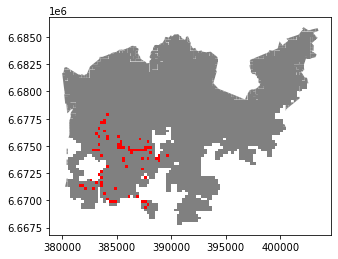

In [18]:
# Create a GeoDataFrame
selection = gpd.GeoDataFrame([dissolved.loc[15]], crs=dissolved.crs)

# Plot all the grid cells, and the grid cells that are 15 minutes a way from the Railway Station
ax = dissolved.plot(facecolor='gray')
selection.plot(ax=ax, facecolor='red')

### Simplifying geometries
Sometimes it might be useful to be able to simplify geometries. This could be something to consider for example when you have very detailed spatial features that cover the whole world. If you make a map that covers the whole world, it is unnecessary to have really detailed geometries because it is simply impossible to see those small details from your map. Furthermore, it takes a long time to actually render a large quantity of features into a map. Here, we will see how it is possible to simplify geometric features in Python.

As an example we will use data representing the Amazon river in South America, and simplify it’s geometries.

Let’s first read the data and see how the river looks like:

PROJCS["Mercator_2SP",GEOGCS["GCS_GRS 1980(IUGG, 1980)",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Unknown",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",-2],PARAMETER["central_meridian",-43],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<AxesSubplot:>

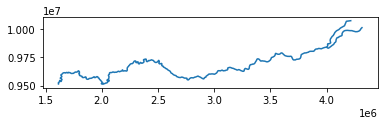

In [41]:
import geopandas as gpd

# File path
fp = "data/Amazon_river.shp"
data = gpd.read_file(fp)

# Print crs
print(data.crs)

# Plot the river
data.plot()

The LineString that is presented here is quite detailed, so let’s see how we can generalize them a bit. As we can see from the coordinate reference system, the data is projected in a metric system using Mercator projection based on SIRGAS datum.

Generalization can be done easily by using a Shapely function called .simplify(). The tolerance parameter can be used to adjusts how much geometries should be generalized. The tolerance value is tied to the coordinate system of the geometries. Hence, the value we pass here is 20 000 meters (20 kilometers).

<AxesSubplot:>

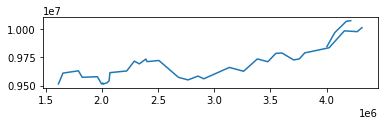

In [42]:
# Generalize geometry
data['geom_gen'] = data.simplify(tolerance=20000)

# Set geometry to be our new simlified geometry
data = data.set_geometry('geom_gen')

# Plot 
data.plot()

In [30]:
data.head()

,bbox_east,bbox_north,bbox_south,bbox_west,place_name,geometry,geom_gen
0,-49.10927,0.70653,-4.44219,-73.450126,"Rio Amazonas, Microrregião de Manaus, Mesorreg...","MULTILINESTRING ((1612358.589 9508606.173, 161...","MULTILINESTRING ((1612358.589 9508606.173, 239..."


## Case: hospital districts
In this tutorial, we will create boundaries of Finnish hospital districts (sairaanhoitopiiri in Finnish) by dissolving municipality boundaries into larger entities. Main processing steps include a table join and dissolving the municipality geometries into larger entities.

We will combine information from municipality polygons from Statistics Finland and a list of health care districts by the Finnish Municipality authority Kuntaliitto.

Importing required python packages:

In [49]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import requests
import geojson

### Read in data
- **Municipality polygons from Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html**

        - wfs: http://geo.stat.fi/geoserver/tilastointialueet/wfs?

        - feature: tilastointialueet:kunta1000k (most recent information about municipality polygons)

In [52]:
# For available features, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = "https://geo.stat.fi/geoserver/tilastointialueet/wfs"

proxies = {
 "http": "http://10.1.10.99:8080",
 "https": "http://10.1.10.99:8080"
}

params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='tilastointialueet:kunta1000k', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params, proxies=proxies)

# Create GeoDataFrame from geojson
geodata = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

In [55]:
geodata.head()

,geometry,kunta,vuosi,nimi,namn,name,bbox
0,"POLYGON ((366787.924 7001300.583, 364487.590 6...",005,2022,Alajärvi,Alajärvi,Alajärvi,"[320404.452, 6959056.438, 366787.924, 7005913...."
1,"POLYGON ((382543.364 7120022.976, 382899.505 7...",009,2022,Alavieska,Alavieska,Alavieska,"[360962.992, 7104339.038, 382899.505, 7133254...."
2,"POLYGON ((343298.204 6961570.195, 343831.847 6...",010,2022,Alavus,Alavo,Alavus,"[303353.32, 6920033.249, 346286.633, 6963078.849]"
3,"POLYGON ((436139.680 6798279.085, 435714.468 6...",016,2022,Asikkala,Asikkala,Asikkala,"[403321.352, 6774122.311, 442401.762, 6804050.61]"
4,"POLYGON ((426631.036 6720528.076, 428821.749 6...",018,2022,Askola,Askola,Askola,"[412974.561, 6704555.878, 435459.201, 6720633...."


In [56]:
# Check length (there are 310 municipalities in Finland in 2020)
len(geodata)

309

In [57]:
#Select and rename columns
geodata.rename(columns={'kunta':'code'}, inplace=True)
geodata = geodata[['code','name', 'geometry']]
geodata.head()

,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


<AxesSubplot:>

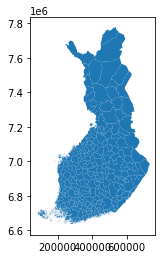

In [58]:
geodata.plot()

In [59]:
geodata.dtypes

code          object
name          object
geometry    geometry
dtype: object

- **Finnish municipalities with hospital district information as an Excel spreadsheet**

        - Downloaded from: https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat in March 2020.

        - File Shp_jäsenkunnat_2020.xls, sheet kunnat_shp_2020_ aakkosjärj. This is the original unaltered file.

        - In this file, “shp” stands for “sairaanhoitopiiri” (hospital district in Finnish)

Note: this data set does not include Åland (Ahvenanmaa). Åland municipalities are added in the later step. Note: “hospital districts” is a more proper translation to sairaanhoitopiirit, but in this lesson I use “health care districts” to refer to these entities

Excel files often come with additional formatting such as metadata on the first lines of the data array. This is why it is a good idea to download the file on your own computer and have a look at the data structure before reading in the file using Python. It is also often a good idea to save the file as a csv file before reading in the data. However, it is also possible to read in data directly from Excel. For this, you need to have the xlrd module installed.

Now we are ready to read in the data using pandas.

In the case of this health districts excel the header is located on the 4th row (index 3) of the excel spreadsheet.

In [95]:
# Read in the csv
data = pd.read_csv("data/Shp_jäsenkunnat_2020.csv", encoding="ISO-8859-1", header=2, sep=';')

In [96]:
data.drop('Unnamed: 6', axis=1, inplace=True)
data.dropna(inplace=True)
len(data)

294

In [97]:
data

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0
5,16.0,Asikkala,7.0,Päijät-Häme,HYKS,5.0
...,...,...,...,...,...,...
290,977.0,Ylivieska,18.0,Pohjois-Pohjanmaa,OYS,290.0
291,980.0,Ylöjärvi,6.0,Pirkanmaa,TAYS,291.0
292,981.0,Ypäjä,5.0,Kanta-Häme,TAYS,292.0
293,989.0,Ähtäri,15.0,Etelä-Pohjanmaa,TAYS,293.0


In [98]:
# Rename columns from Finnish to English 
data.rename(columns={"kunta-\nkoodi":"code", 'sairaanhoitopiiri':'healthCareDistrict'}, inplace=True)

# Select only useful columns
data = data[['code','healthCareDistrict']]

In [99]:
data.head()

,code,healthCareDistrict
1,20.0,Pirkanmaa
2,5.0,Etelä-Pohjanmaa
3,9.0,Pohjois-Pohjanmaa
4,10.0,Etelä-Pohjanmaa
5,16.0,Päijät-Häme


Looks better! Now we need to prepare the data for table join. We will use the municipality code as the common key.

The code column is currently a floating point number. We need to modify these codes so that they match the ones in the spatial data:

In [100]:
# Convert to character string
datac = data.copy()

datac.loc[:, "code"] = datac.loc[:, "code"].astype(int).astype('str')

# Add missing zeros to municipality codes
datac.loc[:, "code"] = datac.loc[:, "code"].str.zfill(3)
datac.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


### Join Health district info to the municipality polygons

In [102]:
# Merge health district info to geodata using "code" as the common key
geodata = geodata.merge(datac, on="code", how="left")

In [104]:
geodata.head()

,code,name,geometry,healthCareDistrict
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6...",Etelä-Pohjanmaa
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7...",Pohjois-Pohjanmaa
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6...",Etelä-Pohjanmaa
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6...",Päijät-Häme
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6...",HUS


In [105]:
# List all municipalities that lack health district info:
geodata[geodata["healthCareDistrict"].isnull()].name

7          Brändö
8          Eckerö
15       Finström
17          Föglö
18           Geta
24     Hammarland
57         Jomala
111      Kumlinge
121         Kökar
134       Lemland
147    Lumparland
153     Mariehamn
236       Saltvik
254      Sottunga
256          Sund
301         Vårdö
Name: name, dtype: object

In [106]:
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
geodata.loc[geodata["healthCareDistrict"].isnull(), "healthCareDistrict"] = "Ahvenanmaa"

In [108]:
# Check the count of municipalities per health care disctrict
geodata["healthCareDistrict"].value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
Ahvenanmaa           16
Satakunta            16
Lappi                15
Vaasa                13
Pohjois-Karjala      13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Savo            9
Etelä-Karjala         9
Kainuu                8
Kymenlaakso           6
Länsi-Pohja           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

### Create polygons for health care districts

In [109]:
# Dissolve (=combine) municipality polygon geometries for each health care district
districts = geodata.dissolve(by='healthCareDistrict')
districts.reset_index(inplace=True)

In [110]:
# Select useful columns
districts = districts[["healthCareDistrict", "geometry"]]
districts

,healthCareDistrict,geometry
0,Ahvenanmaa,"MULTIPOLYGON (((103581.908 6654417.487, 103561..."
1,Etelä-Karjala,"POLYGON ((592557.900 6768951.300, 592411.200 6..."
2,Etelä-Pohjanmaa,"POLYGON ((222946.328 6887833.806, 220077.099 6..."
3,Etelä-Savo,"POLYGON ((520632.817 6786551.176, 520842.240 6..."
4,HUS,"MULTIPOLYGON (((272126.112 6633609.689, 272356..."
5,Itä-Savo,"POLYGON ((576521.513 6897469.199, 578274.261 6..."
6,Kainuu,"POLYGON ((592736.498 7080090.685, 582878.126 7..."
7,Kanta-Häme,"POLYGON ((338216.004 6726835.900, 336263.847 6..."
8,Keski-Pohjanmaa,"MULTIPOLYGON (((301448.483 7083443.419, 301635..."
9,Keski-Suomi,"POLYGON ((389079.739 6882556.808, 381259.133 6..."


(40857.339215, 765862.479085, 6575077.820610001, 7833703.7515899995)

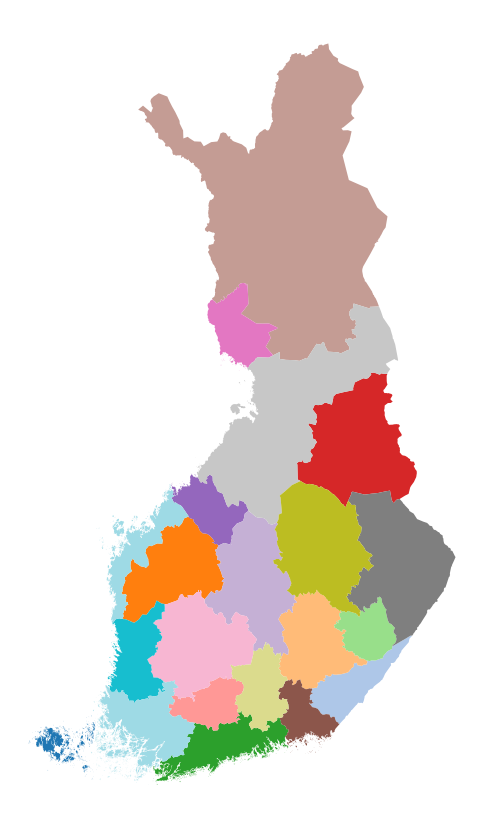

In [116]:
districts.plot(column='healthCareDistrict', cmap='tab20', k=20, figsize=(15,15))
plt.axis('off')

In [126]:
# Write GeoJSON in original projection
districts = districts.set_crs("EPSG:3067")
districts.to_file("data/healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding='utf-8')

In [130]:
# Re-project to WGS84 and save again
wgs84 = CRS.from_epsg(4326)
districts.to_crs(wgs84).to_file("data/healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding='utf-8')

## Data reclassification
Reclassifying data based on specific criteria is a common task when doing GIS analysis. The purpose of this lesson is to see how we can reclassify values based on some criteria. We could, for example, classify information based on travel times and housing prices using these criteria:

In this tutorial, we will:

1. Use classification schemes from the PySAL mapclassify library to classify travel times into multiple classes.

2. Create a custom classifier to classify travel times and distances in order to find out good locations to buy an apartment with these conditions:

        - good public transport accessibility to city center

        - bit further away from city center where the prices are presumably lower
        
### Input data
We will use Travel Time Matrix data from Helsinki that contains travel time and distance information for routes between all 250 m x 250 m grid cell centroids (n = 13231) in the Capital Region of Helsinki by walking, cycling, public transportation and car.

In this tutorial, we will use the geojson file generated in the previous section: "data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

Alternatively, you can re-download L4 data and use "data/Travel_times_to_5975375_RailwayStation.shp" as input file in here.

### Common classifiers
**Classification schemes for thematic maps**

PySAL -module is an extensive Python library for spatial analysis. It also includes all of the most common data classifiers that are used commonly e.g. when visualizing data. Available map classifiers in pysal’s mapclassify -module:

Box_Plot

Equal_Interval

Fisher_Jenks

Fisher_Jenks_Sampled

HeadTail_Breaks

Jenks_Caspall

Jenks_Caspall_Forced

Jenks_Caspall_Sampled

Max_P_Classifier

Maximum_Breaks

Natural_Breaks

Quantiles

Percentiles

Std_Mean

User_Defined

First, we need to read our Travel Time data from Helsinki:

In [134]:
import geopandas as gpd

fp = "data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

# Read the GeoJSON file similarly as Shapefile
acc = gpd.read_file(fp)

# Let's see what we have
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.224 6685750.000, 402003.328 6..."
1,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6..."
2,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.515 6685750.000, 403243.781 6..."
3,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6..."
4,29411,40,29418,44,5878128,29944,75,95,24938,76,99,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((401900.425 6685500.000, 402000.000 6..."


As we can see, there are plenty of different variables (see from here the description for all attributes) but what we are interested in are columns called pt_r_tt which is telling the time in minutes that it takes to reach city center from different parts of the city, and walk_d that tells the network distance by roads to reach city center from different parts of the city (almost equal to Euclidian distance).

The NoData values are presented with value -1.

- Thus we need to remove the No Data values first.

In [135]:
# Include only data that is above or equal to 0
acc = acc.loc[acc['pt_r_tt'] >=0]

- Let’s plot the data and see how it looks like

- cmap parameter defines the color map. Read more about choosing colormaps in matplotlib

- scheme option scales the colors according to a classification scheme (requires mapclassify module to be installed):

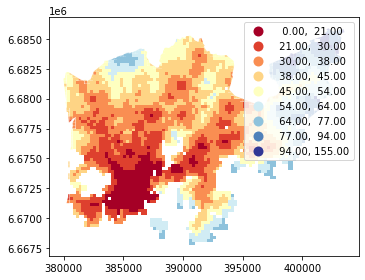

In [137]:
import matplotlib.pyplot as plt

# Plot using 9 classes and classify the values using "Natural Breaks" classification
acc.plot(column="pt_r_tt", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

# Use tight layout
plt.tight_layout()

As we can see from this map, the travel times are lower in the south where the city center is located but there are some areas of “good” accessibility also in some other areas (where the color is red).

- Let’s also make a plot about walking distances:

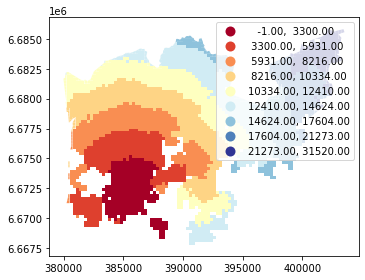

In [138]:
# Plot walking distance
acc.plot(column="walk_d", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

# Use tight layour
plt.tight_layout()

### Applying classifiers to data
As mentioned, the scheme option defines the classification scheme using pysal/mapclassify. Let’s have a closer look at how these classifiers work.

In [139]:
import mapclassify

In [140]:
# Natural Breaks

mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)

NaturalBreaks           

    Interval       Count
------------------------
[  0.00,  21.00] |   263
( 21.00,  31.00] |   613
( 31.00,  38.00] |   789
( 38.00,  45.00] |   820
( 45.00,  54.00] |   512
( 54.00,  66.00] |   416
( 66.00,  79.00] |   185
( 79.00,  96.00] |   159
( 96.00, 155.00] |    50

In [141]:
# Quantiles (default is 5 classes):

mapclassify.Quantiles(y=acc['pt_r_tt'])

Quantiles               

    Interval       Count
------------------------
[  0.00,  30.00] |   792
( 30.00,  37.00] |   779
( 37.00,  44.00] |   821
( 44.00,  56.00] |   685
( 56.00, 155.00] |   730

In [142]:
# It’s possible to extract the threshold values into an array:

classifier = mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)
classifier.bins

array([ 22.,  31.,  37.,  43.,  51.,  61.,  74.,  92., 155.])

- Let’s apply one of the Pysal classifiers into our data and classify the travel times by public transport into 9 classes

- The classifier needs to be initialized first with make() function that takes the number of desired classes as input parameter

In [143]:
# Create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=9)

- Now we can apply that classifier into our data by using apply -function

In [147]:
# Classify the data
classifications = acc[['pt_r_tt']].apply(classifier)

# Let's see what we have
classifications.head()

,pt_r_tt
0,8
1,7
2,8
3,8
4,8


Okay, so now we have a DataFrame where our input column was classified into 9 different classes (numbers 1-9) based on Natural Breaks classification.

- We can also add the classification values directly into a new column in our dataframe:

In [148]:
# Rename the column so that we know that it was classified with natural breaks
acc['nb_pt_r_tt'] = acc[['pt_r_tt']].apply(classifier)

# Check the original values and classification
acc[['pt_r_tt', 'nb_pt_r_tt']].head()

,pt_r_tt,nb_pt_r_tt
0,99,8
1,93,7
2,146,8
3,155,8
4,99,8


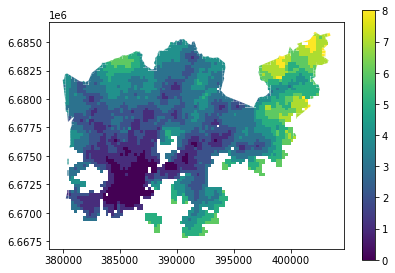

In [149]:
# Plot
acc.plot(column="nb_pt_r_tt", linewidth=0, legend=True)

# Use tight layout
plt.tight_layout()

### Plotting a histogram
A histogram is a graphic representation of the distribution of the data. When classifying the data, it’s always good to consider how the data is distributed, and how the classification shceme divides values into different ranges.

- plot the histogram using pandas.DataFrame.plot.hist

- Number of histogram bins (groups of data) can be controlled using the parameter bins:

<AxesSubplot:ylabel='Frequency'>

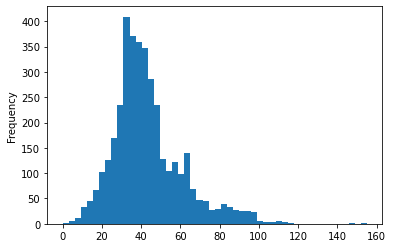

In [151]:
# Histogram for public transport rush hour travel time
acc['pt_r_tt'].plot.hist(bins=50)

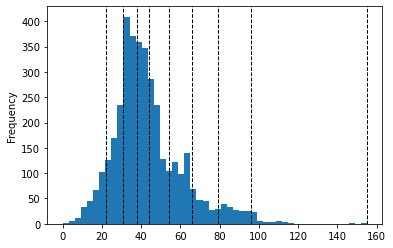

In [152]:
# Natural Breaks
# Define classifier
classifier = mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)

# Plot histogram for public transport rush hour travel time
acc['pt_r_tt'].plot.hist(bins=50)

# Add vertical lines for class breaks
for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)

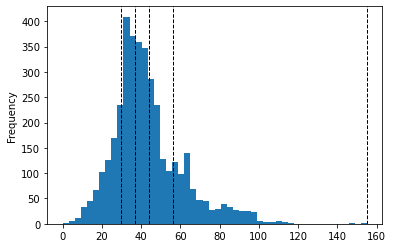

In [154]:
# Quantiles
# Define classifier
classifier = mapclassify.Quantiles(y=acc['pt_r_tt'])

# Plot histogram for public transport rush hour travel time
acc['pt_r_tt'].plot.hist(bins=50)

for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)

### Creating a custom classifier
**Multicriteria data classification**

Let’s create a function where we classify the geometries into two classes based on a given threshold -parameter. If the area of a polygon is lower than the threshold value (average size of the lake), the output column will get a value 0, if it is larger, it will get a value 1. This kind of classification is often called a binary classification.

First we need to create a function for our classification task. This function takes a single row of the GeoDataFrame as input, plus few other parameters that we can use.

It also possible to do classifiers with multiple criteria easily in Pandas/Geopandas by extending the example that we started earlier. Now we will modify our binaryClassifier function a bit so that it classifies the data based on two columns.

- Let’s call it custom_classifier that does the binary classification based on two treshold values:

def custom_classifier(row, src_col1, src_col2, threshold1, threshold2, output_col):
    """Custom classirifer that can be applied on each row of a pandas dataframe (axis=1).
    
    This function classifies data based on values in two source columns and stores the output value in the output column.
    Output values is 1 if the value in src_col1 is LOWER than the threshold1 value AND the value in src_col2 is HIGHER than the threshold2 value. 
    In all other cases, output value is 0.
    
    Args:
        row: one row of data
        src_col1: source column name associated with threshold1
        src_col2: source column name associated with threshold2
        threshold1: upper threshold value for src_col1
        threshold2: lower threshold value for src_col2
        output_col: output column name

    Returns:
        updated row of data.
    """

    # If condition is true, assign 1 into output column
    if row[src_col1] < threshold1 and row[src_col2] > threshold2:
        row[output_col] = 1
    
    # Else, assign 1 into output column
    else:
        row[output_col] = 0

    # Return the updated row
    return row

Now we have defined the function, and we can start using it.

- Let’s do our classification based on two criteria and find out grid cells where the travel time is lower or equal to 20 minutes but they are further away than 4 km (4000 meters) from city center.

- Let’s create an empty column for our classification results called "suitable_area".

In [156]:
# Create column for the classification results
acc["suitable_area"] = None

# Use the function
acc = acc.apply(custom_classifier, 
                src_col1='pt_r_tt', 
                src_col2='walk_d', 
                threshold1=20, 
                threshold2=4000, 
                output_col="suitable_area", 
                axis=1)

# See the first rows
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry,nb_pt_r_tt,suitable_area
0,29476,41,29483,46,5876274,29990,76,95,24984,77,...,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.224 6685750.000, 402003.328 6...",8,0
1,29456,41,29462,46,5876275,29866,74,95,24860,75,...,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6...",7,0
2,36772,50,36778,56,5876278,33541,116,137,44265,130,...,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.515 6685750.000, 403243.781 6...",8,0
3,36898,49,36904,56,5876279,33720,119,141,44444,132,...,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6...",8,0
4,29411,40,29418,44,5878128,29944,75,95,24938,76,...,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((401900.425 6685500.000, 402000.000 6...",8,0


Okey we have new values in suitable_area -column.

- How many Polygons are suitable for us? Let’s find out by using a Pandas function called value_counts() that return the count of different values in our column.

In [158]:
# Get value counts
acc['suitable_area'].value_counts()

0    3798
1       9
Name: suitable_area, dtype: int64

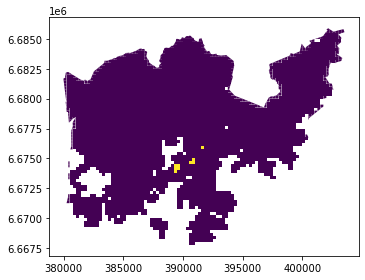

In [159]:
# Plot
acc.plot(column="suitable_area", linewidth=0)

# Use tight layour
plt.tight_layout()